# Capstone Project
## Image classifier for the SVHN dataset

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, we will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Our goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset

In [3]:
X_train = train['X']
y_train = train['y']
X_test = test['X']
y_test = test['y']

In [4]:
print(X_train.shape, y_train.shape)

(32, 32, 3, 73257) (73257, 1)


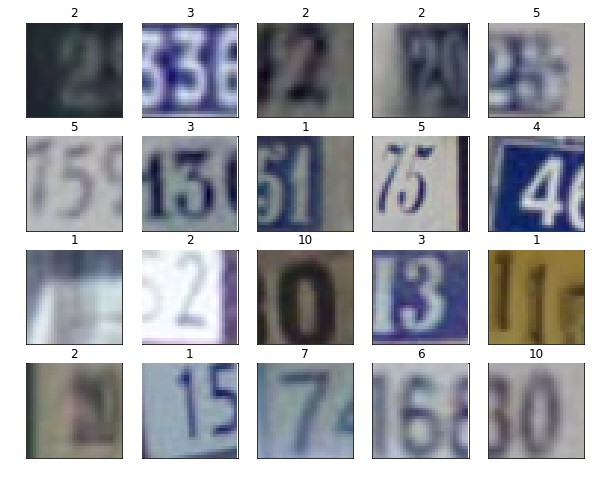

In [5]:
fig, axs = plt.subplots(nrows =4, ncols=5, figsize=(10,8), subplot_kw={'xticks': [], 'yticks':[]})
list_labels = []
for i in range(1, 21):
    rdm_num = np.random.randint(X_train.shape[3], size=1)
    img = X_train[:,:,:,rdm_num]
    fig.add_subplot(4, 5, i)
    plt.imshow(img.squeeze())
    plt.axis('off')
    list_labels.append(y_train[rdm_num])

for i, ax in enumerate(axs.reshape(-1)):
    title = str(list_labels[i]).strip("[]")
    ax.set_title(title)

plt.show()

In [6]:
X_train = X_train.mean(axis=2, dtype="float32").reshape(32, 32, 1, -1)
X_test = X_test.mean(axis=2, dtype="float32").reshape(32, 32, 1, -1)
print(X_train.shape)
print(X_test.shape)

(32, 32, 1, 73257)
(32, 32, 1, 26032)


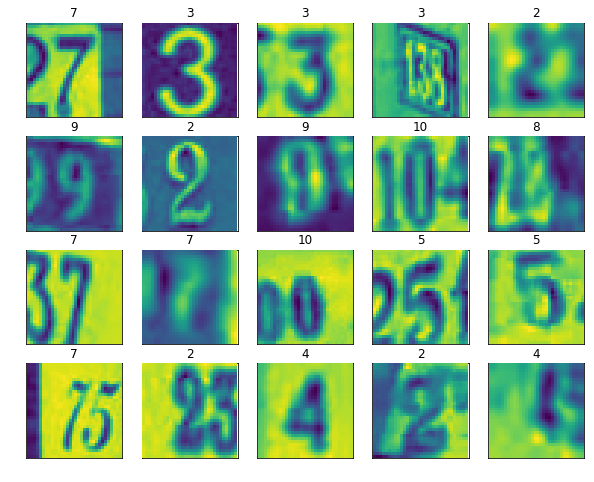

In [7]:
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(10,8), subplot_kw={'xticks':[], 'yticks':[]})
list_labels = []
for i in range(1, 21):
    rdm_num = np.random.randint(X_train.shape[3])
    img = X_train[:,:,:,rdm_num]
    fig.add_subplot(4, 5, i)
    plt.axis('off')
    plt.imshow(img.squeeze())
    list_labels.append(y_train[rdm_num])
    
for i, ax in enumerate(axs.reshape(-1)):
    title = str(list_labels[i]).strip('[]')
    ax.set_title(title)

## 2. MLP neural network classifier

In [8]:
X_train = X_train.T.reshape(-1, 32, 32, 1)
X_train = np.swapaxes(X_train, axis1=1, axis2=2)
X_test = X_test.T.reshape(-1, 32, 32, 1)
X_test = np.swapaxes(X_test, axis1=1, axis2=2)

y_train = y_train.squeeze()
y_test = y_test.squeeze()

In [9]:
X_train.shape

(73257, 32, 32, 1)

In [10]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

In [11]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(73257, 32, 32, 1) (73257,)
(26032, 32, 32, 1) (26032,)


In [12]:
list_labels = np.unique(y_train)

In [13]:
list_labels

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [14]:
y_train_one_hot = to_categorical(y_train - 1, num_classes=10)
y_test_one_hot = to_categorical(y_test - 1, num_classes=10)

In [15]:
weights = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05)
model = Sequential([
    Flatten(input_shape=(32,32,1)),
    Dense(512, activation="relu", kernel_initializer=weights),
    Dense(512, activation="relu", kernel_initializer=weights),
    Dense(256, activation="relu", kernel_initializer=weights),
    Dense(10, activation="softmax")
])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 921,354
Trainable params: 921,354
Non-trainable params: 0
_________________________________________________________________


In [17]:
opt = tf.keras.optimizers.SGD(learning_rate=3e-2)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [18]:
save_best = ModelCheckpoint(filepath='./checkpoints/mlp/model_best_epoch', monitor='loss', mode='min', save_best_only=True, verbose=0, save_weights_only=True)
early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)

In [19]:
history = model.fit(X_train, y_train_one_hot, batch_size=128, epochs=30, validation_split=0.15, callbacks=[save_best, early_stop])

Train on 62268 samples, validate on 10989 samples
Epoch 1/30
62268/62268 [==============================] - 40s 645us/sample - loss: 2.1457 - accuracy: 0.2391 - val_loss: 1.9707 - val_accuracy: 0.3366
Epoch 2/30
62268/62268 [==============================] - 38s 609us/sample - loss: 1.7446 - accuracy: 0.4206 - val_loss: 1.6143 - val_accuracy: 0.4744
Epoch 3/30
62268/62268 [==============================] - 37s 601us/sample - loss: 1.4498 - accuracy: 0.5313 - val_loss: 1.6682 - val_accuracy: 0.4255
Epoch 4/30
62268/62268 [==============================] - 36s 578us/sample - loss: 1.2744 - accuracy: 0.5960 - val_loss: 1.2425 - val_accuracy: 0.6024
Epoch 5/30
62268/62268 [==============================] - 36s 580us/sample - loss: 1.1530 - accuracy: 0.6379 - val_loss: 1.3757 - val_accuracy: 0.5636
Epoch 6/30
62268/62268 [==============================] - 36s 578us/sample - loss: 1.0682 - accuracy: 0.6674 - val_loss: 1.0558 - val_accuracy: 0.6613
Epoch 7/30
62268/62268 [====================

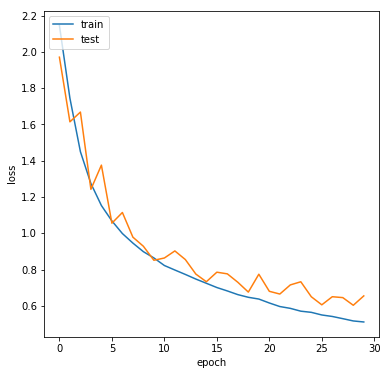

In [20]:
fig, axs = plt.subplots(figsize=(6,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc="upper left")
plt.show()

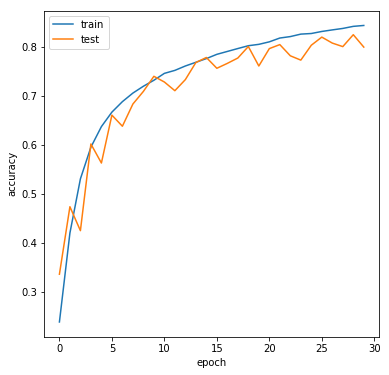

In [21]:
fig, axs = plt.subplots(figsize=(6,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc="upper left")
plt.show()

In [46]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot, verbose=False)
print("Loss on test samples:", np.around(test_loss, 2))
print("Accuracy on test samples:", np.around(test_accuracy*100,2), '%')

Loss on test samples: 0.72
Accuracy on test samples: 79.19 %


## 3. CNN neural network classifier

In [19]:
cnn = Sequential([
    Conv2D(32, (4,4), activation="relu", input_shape=(32,32,1), padding="same"),
    MaxPooling2D((4,4)),
    BatchNormalization(),
    Conv2D(16, (4,4), activation="relu", padding="same"),
    Flatten(),
    Dense(256, activation="relu", kernel_initializer=weights),
    Dropout(0.3),
    Dense(128, activation="relu", kernel_initializer=weights),
    Dense(10, activation="softmax")
])

In [20]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        544       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 32)          128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          8208      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout (Dropout)            (None, 256)              

In [21]:
cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [22]:
save_best_cnn = ModelCheckpoint(filepath='./checkpoints/cnn/model_best_epoch', monitor='loss', mode='min', save_best_only=True, verbose=0, save_weights_only=True)
early_stop_cnn = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)

In [27]:
history_cnn = cnn.fit(X_train, y_train_one_hot, epochs=30, batch_size=512, validation_split=0.15, callbacks=[save_best_cnn, early_stop_cnn])

Train on 62268 samples, validate on 10989 samples
Epoch 1/30
62268/62268 [==============================] - 207s 3ms/sample - loss: 1.3535 - accuracy: 0.5462 - val_loss: 2.0227 - val_accuracy: 0.3453
Epoch 2/30
62268/62268 [==============================] - 206s 3ms/sample - loss: 0.6311 - accuracy: 0.8066 - val_loss: 1.7354 - val_accuracy: 0.5431
Epoch 3/30
62268/62268 [==============================] - 206s 3ms/sample - loss: 0.5107 - accuracy: 0.8415 - val_loss: 1.1602 - val_accuracy: 0.7321
Epoch 4/30
62268/62268 [==============================] - 204s 3ms/sample - loss: 0.4538 - accuracy: 0.8602 - val_loss: 0.7182 - val_accuracy: 0.8288
Epoch 5/30
62268/62268 [==============================] - 200s 3ms/sample - loss: 0.4071 - accuracy: 0.8738 - val_loss: 0.4529 - val_accuracy: 0.8705
Epoch 6/30
62268/62268 [==============================] - 201s 3ms/sample - loss: 0.3747 - accuracy: 0.8856 - val_loss: 0.3945 - val_accuracy: 0.8843
Epoch 7/30
62268/62268 [==========================

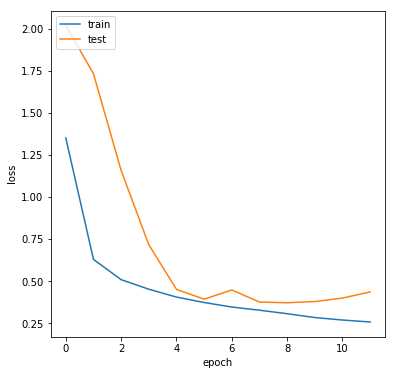

In [28]:
fig, axs = plt.subplots(figsize=(6,6))
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc="upper left")
plt.show()

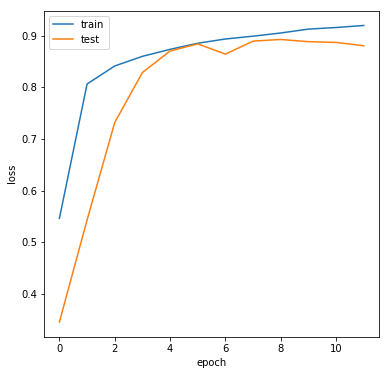

In [29]:
fig, axs = plt.subplots(figsize=(6,6))
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc="upper left")
plt.show()

In [44]:
test_loss_cnn, test_accuracy_cnn = cnn.evaluate(X_test, y_test_one_hot, verbose=False)
print("Loss on test samples:", np.around(test_loss_cnn, 2))
print("Accuracy on test samples:", np.around(test_accuracy_cnn*100,2), '%')

Loss on test samples: 0.47
Accuracy on test samples: 87.19 %


## 4. Get model predictions

In [23]:
model.load_weights(tf.train.latest_checkpoint('./checkpoints/mlp/'))
cnn.load_weights(tf.train.latest_checkpoint('./checkpoints/cnn/'))

In [55]:
images = []
labels = []
predictions_mlp = []
predictions_cnn = []

for i in range(0, 5):
    rdm_num = np.random.randint(X_test.shape[0], size=1) 
    img = X_test[rdm_num, :,:,:]
    images.append(img)
    labels.append(str(y_test[rdm_num]).strip('[]'))
    predictions_mlp.append(model.predict(img))
    predictions_cnn.append(cnn.predict(img))

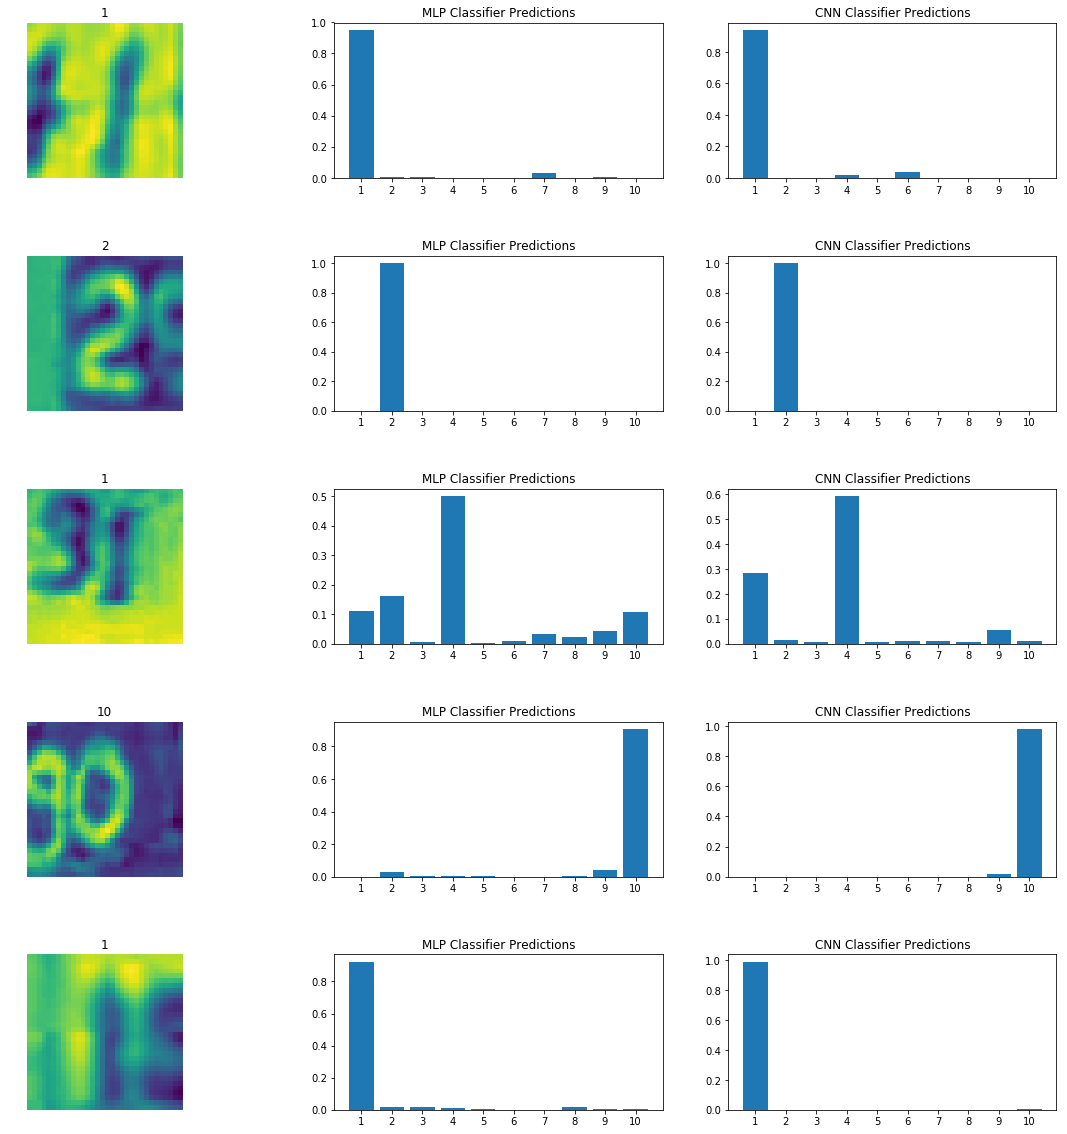

In [60]:
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(20,20))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

x = np.arange(1,11)

for i, (image, label, mlp_prediction, cnn_prediction) in enumerate(zip(images, labels, predictions_mlp, predictions_cnn)):
    axs[i, 0].imshow(np.squeeze(image))
    axs[i, 0].set_title(label)
    axs[i, 0].axis('off')
    axs[i, 1].bar(x, mlp_prediction.reshape(10,))
    axs[i, 1].set_title('MLP Classifier Predictions')
    axs[i, 1].set_xticks(x)
    axs[i, 2].bar(x, cnn_prediction.reshape(10,))
    axs[i, 2].set_title('CNN Classifier Predictions')
    axs[i, 2].set_xticks(x)
    